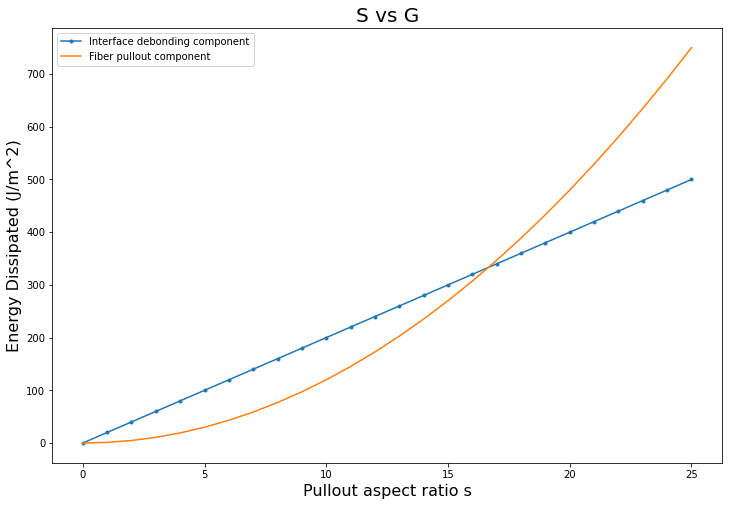

In [20]:
###Problem 4 

import numpy as np
import math as m
import matplotlib.pyplot as plt 

Vf = 0.4
Gic = 50 
tau_crit = 3e6
r = 3e-6

Gcd_list = []
Gcp_list = []

s = [s for s in range(26)]
plt.figure(figsize = (12,8))
for s_value in s:
    Gcd = Vf*s_value*Gic
    Gcp = 0.33333*Vf*(s_value**2)*r*tau_crit
    Gcd_list.append(Gcd)
    Gcp_list.append(Gcp)
    

        
    
plt.plot(s,Gcd_list,'.-',label = 'Interface debonding component')    
plt.plot(s,Gcp_list,'-',label = 'Fiber pullout component') 
plt.xlabel('Pullout aspect ratio s',fontsize = 16)
plt.ylabel('Energy Dissipated (J/m^2)',fontsize = 16)
plt.title('S vs G', fontsize = 20)
plt.legend();

    

In [25]:
##  There is a transition in dominant mechanism in the interval 16 < s < 17 
##  Increase  in energy dissipated from an aspect ratio of 𝑠=1to 𝑠=25:

s1_G = Gcd_list[1] + Gcp_list[1]
s25_G = Gcd_list[25] + Gcp_list[25]

Increase = s25_G - s1_G
print(Increase, 'J/m^2')




1228.792512 J/m^2


In [45]:
### Problem 6 

import numpy as np
import math as m

def rotaT(theta):
    '''Matrix for stress rotation in 2D.'''
    c = np.cos(np.deg2rad(theta))
    s = np.sin(np.deg2rad(theta))
    return np.array([[c**2, s**2, 2*s*c],[s**2, c**2, -2*s*c],[-s*c, s*c, c**2-s**2]])

def rotaTP(theta):
    '''Matrix for strain rotation in 2D.'''
    c = np.cos(np.deg2rad(theta))
    s = np.sin(np.deg2rad(theta))
    return np.array([[c**2, s**2, s*c],[s**2, c**2, -s*c],[-2*s*c, 2*s*c, c**2-s**2]])

def rotateStrain(strain, theta):
    '''Rotate 2D strain counterclockwise. Input  strain as a 3x1 vector'''
    TP = rotaTP(theta)
    return TP.dot(strain)

def rotateStress(stress, theta):
    '''Rotate 2D stress counterclockwise. Input stress as a 3x1 vector'''
    T = rotaT(theta)
    return T.dot(stress)

def rotateStiffness(C, theta):
    '''Rotate the 2D stiffness tensor C counterclockwise by angle theta.'''
    # Define rotation matrix T and T'
    T = rotaT(theta)
    TP = rotaTP(theta)

    # Stress tensor rotations
    return np.linalg.inv(T).dot(C).dot(TP)
def tsaiHillFail(stress, s1, s2, s12):
    '''Determine whether a composite will fail under a Tsai-Hill condition.
    Takes an input stress in 2D (aligned with the fiber direction) and strengths
    in the 1, 2, and 12 direction. Will return true or false.'''
    return (stress[0]/s1)**2+(stress[1]/s2)**2-stress[0]*stress[1]/s1**2+(stress[2]/s12)**2 > 1

def laminaFail(stress, th, s1, s2, s12, criterion='Tsai-Hill'):
    '''Determine whether an arbitrary load will cause failure. Takes an input stress
    in 2D, an angle th, strengths in the 1, 2 and 12 direction, and the criterion to
    be used. Returns true or false.'''
    # Rotate stress
    s = rotateStress(stress,th)

    # Determine failure
    if criterion == 'Tsai-Hill':
        return tsaiHillFail(s, s1, s2, s12)
    elif criterion == 'Max Stress':
        return maxStressFail(s, s1, s2, s12)
    
def laminateStiffness(C, thetas, ts):
    '''Return the stiffness of a laminate given a single input C aligned with the
    fiber orientation of the base material, an array of angles corresponding to the
    laminate stack and an array of thicknesses ts corresponding to each lamina.'''
    return sum([rotateStiffness(C,theta)*t for theta,t in zip(thetas,ts)])/sum(ts)

def FirstPlyFail(stress_g,thetas,thicknesses,C,sig1,sig2,tau12):
    C_g = laminateStiffness(C,thetas, thicknesses)
    S_g = np.linalg.inv(C_g)
    
    stress_ks = []
    for angle in thetas:
        C_k = rotateStiffness(C,angle)
        TP = rotaTP(angle)
        stress_k = C_k.dot(TP).dot(S_g).dot(stress_g)
        stress_ks.append(stress_k)
        
    i = 0
    for stress in stress_ks:
        i+=1
        a = tsaiHillFail(stress,sig1,sig2,tau12)
        if a == True:
            print('The {} ply fails at a stress of {}'.format(i,stress))

In [ ]:
def eta(P1, P2, xi):
    '''Function used in the Halpin-Tsai relationships.'''
    return ((P1/P2)-1)/((P1/P2)+xi)

def transIsoStiffness(E1, nu1, E2, nu2, V, HT=True):
    '''Return the 2D stiffness tensor of a transversely isotropic composite made
       from materials 1 and 2. Inputs required are the stiffness and Poisson's ratio of
       both materials (E1, nu1, E2, nu2) and volume fraction V of material 1.
       Properties are calculated using Halpin-Tsai relationships by default (HT = True),
       but a Reuss model can be used if desired.'''

    # Calculate Base Material Properties
    G1 = E1/(2*(1+nu1))
    G2 = E2/(2*(1+nu2))

    # Calculate Material Properties
    Ex = E1*V + E2*(1-V) #Voigt

    if HT: #Halpin-Tsai
        Ey = E2*(1 + 2*eta(E1,E2,2)*V)/(1 - eta(E1,E2,2)*V)
        Gxy = G2*(1 + 1*eta(G1,G2,1)*V)/(1 - eta(G1,G2,1)*V)
    else: #Reuss
        Ey = 1/(V/E1+(1-V)/E2)
        Gxy = 1/(V/G1+(1-V)/G2)

    nuxy = nu1*V+nu2*(1-V) #Voigt
    nuyx = nuxy*Ey/Ex #Reciprocal

    # Create Stiffness Matrix
    C = [[Ex/(1-nuxy*nuyx),      nuyx*Ex/(1-nuxy*nuyx), 0],
         [nuyx*Ex/(1-nuxy*nuyx), Ey/(1-nuxy*nuyx),      0],
         [0,                     0,                     Gxy]]

    return np.array(C)

C = transIsoStiffness(350e9,0.21,3.4e9,0.42,0.65)

for sig_0 in range(1000000,200000000,1000000):
    print('For loading {}'.format(sig_0))
    FirstPlyFail(np.array([[3*sig_0],[1*sig_0],[2*sig_0]]),[0,30,45,60,90,90,60,45,30,0],[0.0005,0.001,0.0005,0.001,0.0005,0.0005,0.001,0.0005,0.001,0.0005],C,2.1e9,75e6,160e6)

In [ ]:
### Therefore the lamina fails at sig_0 = 16 MPa
### Ply #4 (60 deg) fails at a stress of [-19091974.45863348],[-72572087.49971014],[-47181968.2060298 ]